In [7]:
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import os
from collections import namedtuple
import pickle
import matplotlib.pyplot as plt

In [8]:
Mask_Info = namedtuple('Mask_Info', ['mask', 'actual_iou','stability_score', 'max_stability_score', 'min_stability_score'])

sam = sam_model_registry["vit_h"](checkpoint="sam_models/sam_vit_h_4b8939.pth")
sam.to(device='cuda')
mask_generator = SamAutomaticMaskGenerator(sam)

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    
    return img

def compute_vectorized_iou(given_mask, masks):
    given_mask_expanded = np.expand_dims(given_mask, axis=0)
    masks_expanded = np.stack(masks)
    intersection = np.logical_and(masks_expanded > 0, given_mask_expanded > 0)
    union = np.logical_or(masks_expanded > 0, given_mask_expanded > 0)
    intersection_sum = np.sum(intersection, axis=(1, 2))
    union_sum = np.sum(union, axis=(1, 2))
    iou_values = intersection_sum / union_sum
    return iou_values

def generateBestPatchMask(image, gt_mask):
    masks = mask_generator.generate(image)
    annotated_img = show_anns(masks)
    all_masks = []
    predicted_ious = []
    stability_scores = []
    for i, meta_info in enumerate(masks):
        all_masks.append(meta_info['segmentation'])
        predicted_ious.append(meta_info['predicted_iou'])
        stability_scores.append(meta_info['stability_score'])

    actual_ious = compute_vectorized_iou(gt_mask, all_masks)
    # print(np.argmax(actual_ious))
    best_iou_idx = np.argmax(actual_ious)
    closest_patch = masks[best_iou_idx]['segmentation']
    mask_info = Mask_Info(closest_patch, actual_ious[best_iou_idx], stability_scores[best_iou_idx], np.max(stability_scores), np.min(stability_scores))
    return mask_info, annotated_img

In [10]:
data_path = 'ftp.cis.jhu.edu/pub/apricot-mask/data_mask_v2'
file_names = os.listdir(data_path)

In [11]:
stability_scores = []
iou_scores = []
max_stability_scores = []
min_stability_scores = []

num_images = 0
for file_name in file_names:
	data = torch.load(os.path.join(data_path, file_name))
	img = 255.0 * np.squeeze(data['Image'])
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)
	img = img.astype(np.uint8)

	gt_mask = 255.0 * np.squeeze(data['Mask'])
	gt_mask  = cv2.resize(gt_mask, (512,512), interpolation = cv2.INTER_AREA)
	gt_mask = gt_mask.astype(np.uint8)

	mask_info, _ = generateBestPatchMask(img, gt_mask)

	stability_scores.append(mask_info.stability_score)
	max_stability_scores.append(mask_info.max_stability_score)
	min_stability_scores.append(mask_info.min_stability_score)

	iou_scores.append(mask_info.actual_iou)

	num_images += 1

	if num_images % 100 == 0:
		print("Completed {} images".format(num_images))
	# break

Completed 100 images
Completed 200 images
Completed 300 images
Completed 400 images
Completed 500 images
Completed 600 images
Completed 700 images
Completed 800 images


In [12]:
# Save variables

# with open('variables.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([stability_scores, iou_scores, max_stability_scores, min_stability_scores], f)

In [13]:
with open('variables.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    stability_scores, iou_scores, max_stability_scores, min_stability_scores = pickle.load(f)

In [14]:
print(min_stability_scores)

[0.9501378536224365, 0.9501779079437256, 0.9512670636177063, 0.9508670568466187, 0.9503311514854431, 0.9500356912612915, 0.9500188231468201, 0.9503722190856934, 0.9501185417175293, 0.949999988079071, 0.949999988079071, 0.9514472484588623, 0.9511567950248718, 0.9506818056106567, 0.9522157907485962, 0.9531981348991394, 0.9501187801361084, 0.9501569867134094, 0.9505876302719116, 0.949999988079071, 0.9503105878829956, 0.9504289627075195, 0.9507692456245422, 0.9500875473022461, 0.9514874219894409, 0.9504643678665161, 0.9519199728965759, 0.9501915574073792, 0.9504109621047974, 0.9507221579551697, 0.9516971111297607, 0.950248658657074, 0.9502352476119995, 0.9502676129341125, 0.955078125, 0.9501962661743164, 0.949999988079071, 0.9512761235237122, 0.9507877826690674, 0.9508299231529236, 0.950016975402832, 0.9513888955116272, 0.9560439586639404, 0.9501833319664001, 0.9507575631141663, 0.9501039385795593, 0.9521360993385315, 0.9511906504631042, 0.9512820243835449, 0.949999988079071, 0.94999998807

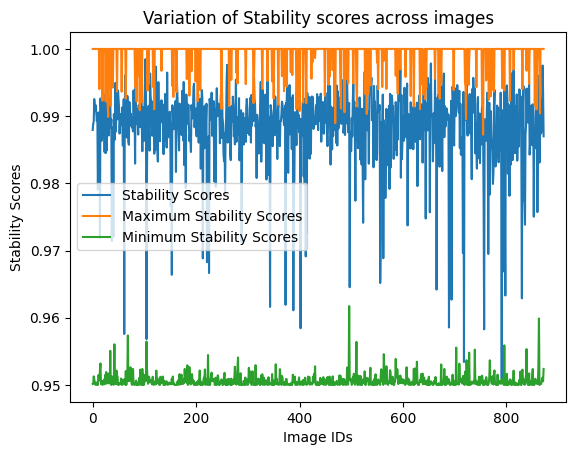

In [15]:
plt.plot(stability_scores, label='Stability Scores')
plt.plot(max_stability_scores, label='Maximum Stability Scores')
plt.plot(min_stability_scores, label='Minimum Stability Scores')

plt.xlabel("Image IDs")
plt.ylabel("Stability Scores")
plt.title("Variation of Stability scores across images")
plt.legend()
plt.show()

In [19]:
print("Average stability scores : {}".format(np.average(stability_scores)))

Average stability scores : 0.9882837675281406


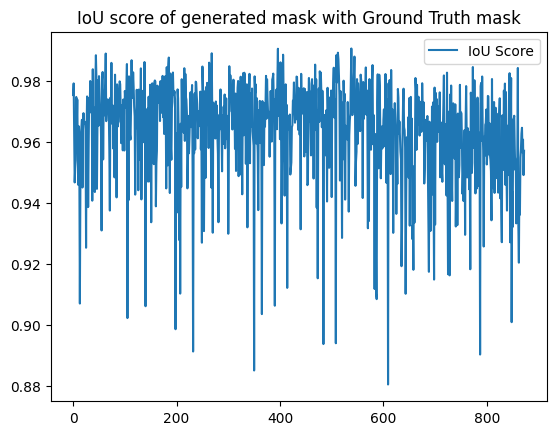

In [16]:
plt.plot(iou_scores, label='IoU Score')
plt.title('IoU score of generated mask with Ground Truth mask')
plt.legend()
plt.show()

In [20]:
print("Average IoU score : {}".format(np.average(iou_scores)))

Average IoU score : 0.9631939023190641
